In [ ]:
import math
!git clone https://github.com/ViktorAnchutin/detecting_active_emotion.git;
!mv detecting_active_emotion/* .

In [ ]:
!pip install transformers --quiet;
!pip install timm --quiet;

In [55]:
import pandas as pd
from itertools import chain
from torch import nn
from data.utils import *
from transformers import Wav2Vec2Model
from experiments.models import W2V2Model, ConvNextModel
from data.dataloader import create_dataloader, MultiDataLoader
from framework.learning_rate import ExponentialLRCalculator,CosineLRCalculator
from experiments.experiment_runner import Training, TrainingConfig
from matplotlib import pyplot as plt
import torchaudio
from tqdm import tqdm
import warnings

warnings.filterwarnings('ignore')

device = "cuda" if torch.cuda.is_available() else "cpu"
w2v_features_path = 'D:/FYP/w2v_features'

# Check that there is an audio backend
if len(torchaudio.list_audio_backends()) <= 0:
    raise RuntimeError("No audio backend detected!")

print(f"Audio backend : {torchaudio.list_audio_backends()[0]}")
print(f"Torch version : {torch.__version__}")
print(f"Device : {device}")
print(f"Torchaudio version : {torchaudio.__version__}")
print(f"Is CUDA available : {torch.cuda.is_available()}")
print(f"CUDA Version : {torch.cuda_version}")
print(f"CUDA Device : {torch.cuda.current_device()}")

Audio backend : soundfile
Torch version : 2.0.1+cu118
Device : cuda
Torchaudio version : 2.0.2+cu118
Is CUDA available : True
CUDA Version : 11.8
CUDA Device : 0


# Annotations preprocessing

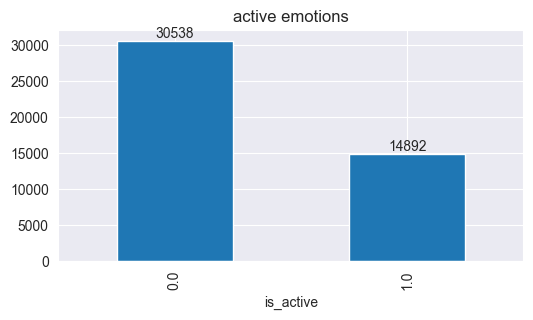

In [56]:
data = pd.read_csv("labels_consensus.csv").set_index("FileName")
data = data[data.SpkrID != 'Unknown']
data['is_active'] = data.apply(lambda x: 1. if x['EmoAct'] >= 5 else 0.,axis=1)

def plot_label(data,label,ax=None,title=None):
  barc = data[label].value_counts().plot.bar(ax=ax,title=title)
  barc.bar_label(barc.containers[0], label_type='edge')

_,ax = plt.subplots(1,figsize=(6, 3));
plot_label(data, 'is_active',ax=ax, title='active emotions');

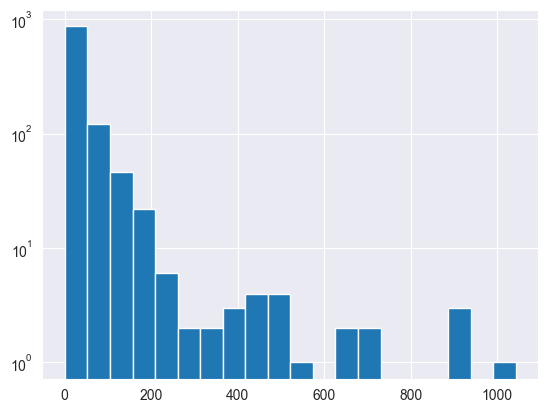

In [57]:
speaker_counts = data.groupby('SpkrID').apply(lambda x: pd.Series({'cnt':len(x)}))
speaker_counts.cnt.hist(log=True,bins=20);

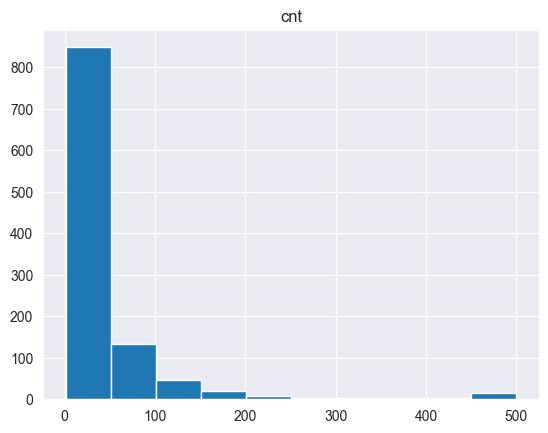

In [58]:
def downsample_speaker(data,speaker,limit=500):
  sampled_ids = data[data['SpkrID'] == speaker].sample(limit).index
  todrop = data[(data['SpkrID'] == speaker)&(~data.index.isin(sampled_ids))].index
  return data.drop(todrop)

for sid in speaker_counts[speaker_counts.cnt >= 500].index:
  data = downsample_speaker(data,sid)

data.groupby('SpkrID').apply(lambda x: pd.Series({'cnt':len(x)})).hist();

# Sampling

Based on what I observed and experienced, training the model using the entire dataset takes up a lot of time (>12 hours) for just 2 epoch and this greatly slows down development speed as when changes are made which require retraining, half a day was wasted. And so I have decided to sample the data instead of using the entire dataset. Although there is a risk of information loss, I think for preliminary experimentation, it is a necessary approach to speed up development and dataset understanding. A few sampling techniques was tried on the train and validation data. The goal is to see which sampling techniques yield a data distribution in sample that it the most similar to the original data distribution. This is so that model can learn as much information as it can from the sampled data due to it having similar variance with original data. The sampling we will be using is random sampling since it output a sample data with distribution closest to the original data. We will sample about 20% of the original data.

In [59]:
import seaborn as sns

def random_sampling_distribution_visualizer(data):
    sample = data.sample(frac=0.1, random_state=1234)
    
    plt.figure(figsize=(8, 4))
    sns.histplot(data['EmoAct'], bins=30, kde=True, color='blue', label='Original Data')
    plt.title('Histogram of Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(8, 4))
    sns.histplot(sample['EmoAct'], bins=30, kde=True, color='red', label='Sample Data')
    plt.title('Histogram of Sampled Data')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.legend()
    
    return sample

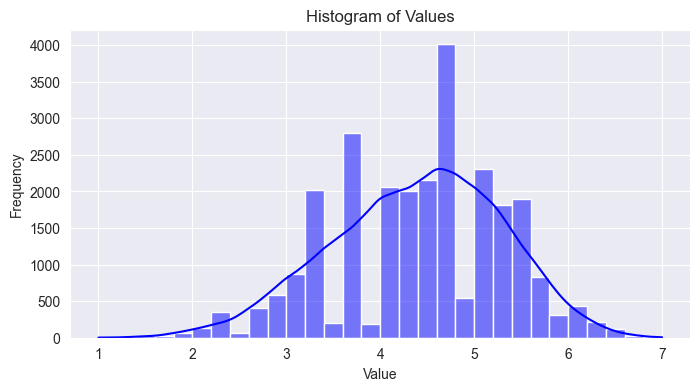

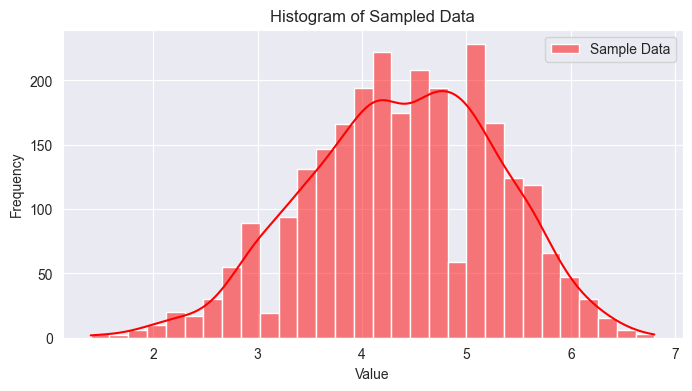

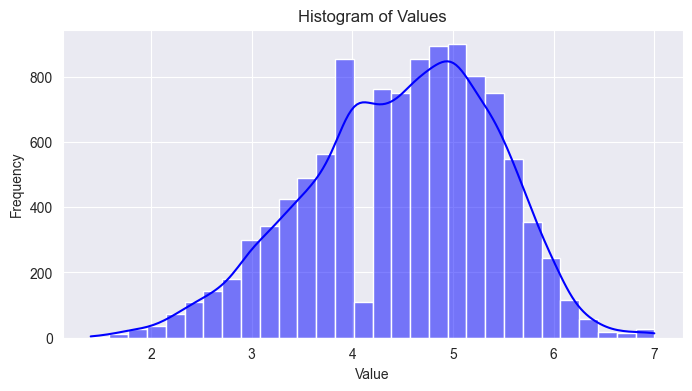

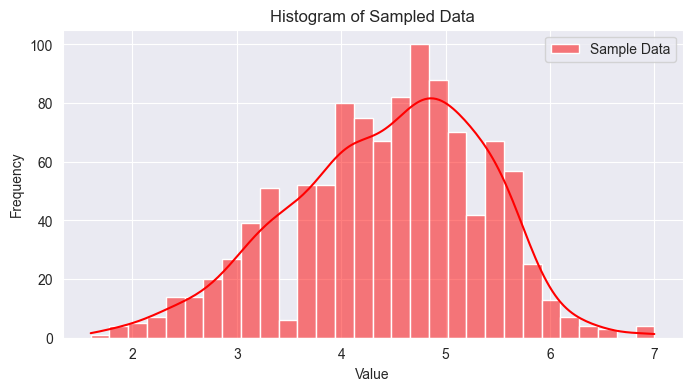

In [60]:
import math

data = data[~data['Split_Set'].isin(['Development', 'Test2'])].copy()
data.loc[:, 'custom_partition'] = data.apply(lambda x: 'Test' if x['Split_Set'] == 'Test1' else 'Train', axis = 1)

train_data = data[data.Split_Set == 'Train']
valid_data = data[data.Split_Set == 'Test1']

sampled_data = []

for dataset in [train_data, valid_data]:
    sampled_data.append(random_sampling_distribution_visualizer(dataset))

train_data = sampled_data[0]
valid_data = sampled_data[1]

dataset = (train_data, valid_data)

,unique speakers
custom_partition,
Test,60
Train,975


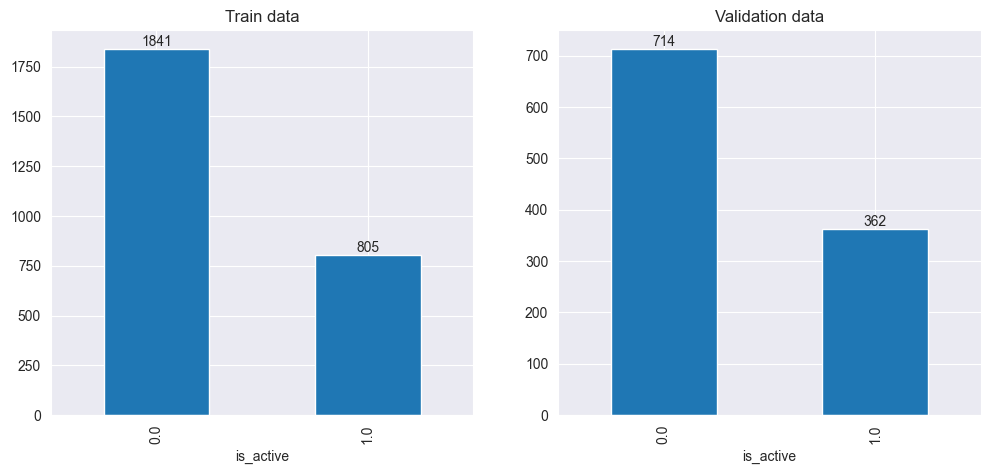

In [61]:
_,ax = plt.subplots(1,2,figsize=(12, 5));
plot_label(train_data, 'is_active', ax=ax[0], title='Train data');
plot_label(valid_data, 'is_active', ax=ax[1], title='Validation data');

data.groupby('custom_partition').apply(lambda x: pd.Series({'unique speakers':len(x.SpkrID.unique())}))

## Collect information about duration

In [62]:
files = []
durations = []
samples = []

for data in dataset:
    for file_name in tqdm(data.index):
      signal, sr = torchaudio.load(f"D:/FYP/0/Audios/Audio/{file_name}")
      files.append(file_name)
      durations.append(signal.shape[1]/sr)
      samples.append(signal.shape[1])

100%|██████████| 1076/1076 [00:01<00:00, 706.48it/s]


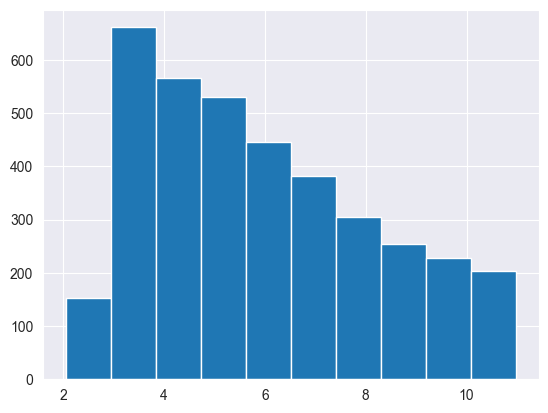

In [63]:
duration_df = pd.DataFrame({"file":files, "samples":samples, "dur":durations}).set_index('file')
train_data = train_data.join(duration_df)
valid_data = valid_data.join(duration_df)
duration_df.dur.hist();

In [64]:
bins=20

train_data['bin'] = pd.cut(train_data.dur, bins=bins, labels=range(bins))
train_data.loc[train_data['bin']==19, 'bin'] = 18 # merge last bin due to only one record

valid_data['bin'] = pd.cut(valid_data.dur, bins=bins, labels=range(bins))

In [65]:
weight = len(train_data[train_data['is_active'] == 0])/len(train_data[train_data['is_active'] == 1])

# Precompute w2v features

W2v convolutional encoder consumes a lot of GPU. To avoid it during training, the features are precomputed.

In [66]:
audios_mean,audios_sdt = (-0.00011539726044066538, 0.07812332811748154)
raw_audio_datasets_train = create_binned_datasets(train_data, partial(create_audio_ds, norms=(audios_mean,audios_sdt)))
raw_audio_datasets_valid = create_binned_datasets(valid_data, partial(create_audio_ds, norms=(audios_mean,audios_sdt)))

w2v_feature_extractor = Wav2Vec2Model.from_pretrained("facebook/wav2vec2-base-960h").feature_extractor


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
!mkdir {w2v_features_path}

for ds in chain(raw_audio_datasets_train, raw_audio_datasets_valid):
  extract_w2v_features(ds, w2v_feature_extractor, w2v_features_path, bs=32, device=device)

The syntax of the command is incorrect.
 50%|█████     | 2/4 [00:10<00:10,  5.27s/it]


KeyboardInterrupt: 

# |Spectrograms binned datasets

In [68]:
window = 640 # 40ms
hop = 320 # 20 ms
mels= 64
spctr_binned_dataset_norms = (-10.58189139511126, 14.482822057824656)
spctr_dataset_builder = partial(create_spectrogram_ds,norms=spctr_binned_dataset_norms,w=window,hop=hop,n_mels=mels)
spctr_ds_train_binned = create_binned_datasets(train_data, spctr_dataset_builder)
spctr_ds_valid_binned = create_binned_datasets(valid_data, spctr_dataset_builder)

# W2V datasets binned

In [69]:
w2v2_datasets_train = create_binned_datasets(train_data, partial(create_file_ds, path=w2v_features_path))
w2v2_datasets_valid = create_binned_datasets(valid_data, partial(create_file_ds, path=w2v_features_path))

# Hybrid

In [16]:
from data.utils import create_hybrid_datasets_binned
from data.dataloader import collate_hybrid

In [17]:
hybrid_datasets_train = create_hybrid_datasets_binned(w2v2_datasets_train, spctr_ds_train_binned)
hybrid_datasets_valid = create_hybrid_datasets_binned(w2v2_datasets_valid, spctr_ds_valid_binned)

In [18]:
hybrid_dl_train = MultiDataLoader(hybrid_datasets_train, partial(create_dataloader, collate_fn=collate_hybrid, bs=8))
hybrid_dl_valid = MultiDataLoader(hybrid_datasets_valid, partial(create_dataloader, collate_fn=collate_hybrid, bs=8))

In [19]:
for ds in chain(hybrid_datasets_train,hybrid_datasets_valid):
  ds.prefetch(1)

100%|██████████| 3/3 [00:00<00:00, 214.32it/s]


Some weights of Wav2Vec2Model were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 19/19 [00:03<00:00,  6.24it/s]


,train_loss,test_loss,auc,f1,recall,precision
0,1.055148,1.1205,0.718117,0.55814,0.631579,0.5


100%|██████████| 19/19 [00:02<00:00,  9.38it/s]


,train_loss,test_loss,auc,f1,recall,precision
1,1.037141,1.091776,0.791498,0.64,0.842105,0.516129


100%|██████████| 19/19 [00:02<00:00,  9.31it/s]


,train_loss,test_loss,auc,f1,recall,precision
2,1.111053,1.086866,0.744939,0.583333,0.736842,0.482759


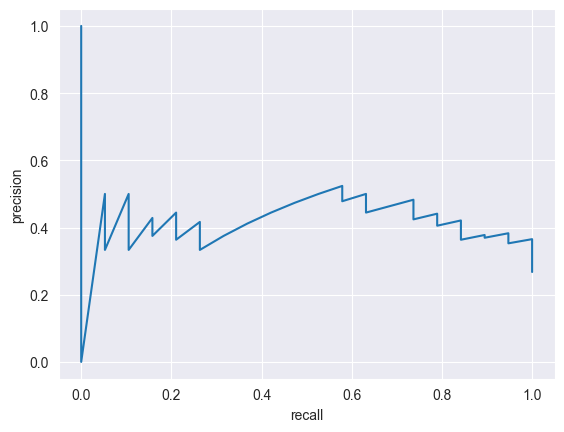

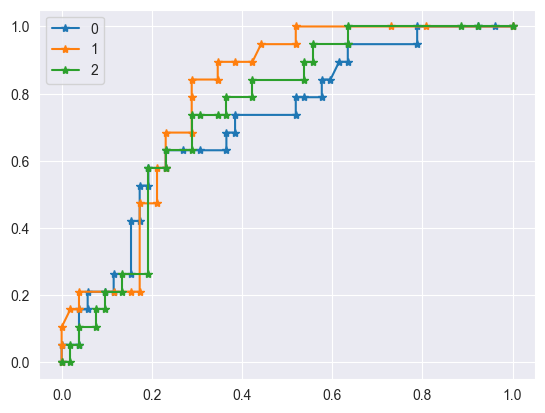

100%|██████████| 19/19 [00:02<00:00,  8.96it/s]


,train_loss,test_loss,auc,f1,recall,precision
0,1.020659,1.083747,0.767713,0.592593,0.842105,0.457143


100%|██████████| 19/19 [00:02<00:00,  6.99it/s]


,train_loss,test_loss,auc,f1,recall,precision
1,1.017256,1.003189,0.802632,0.666667,0.947368,0.514286


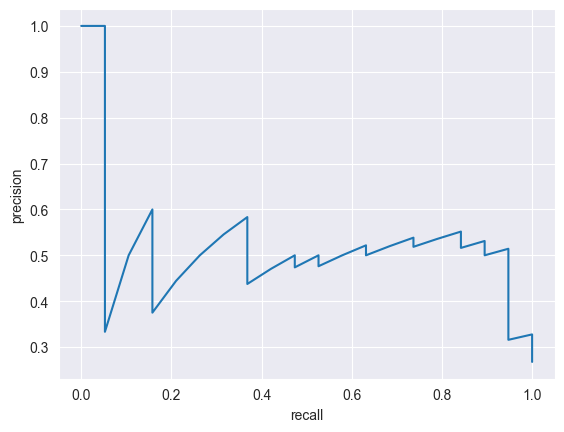

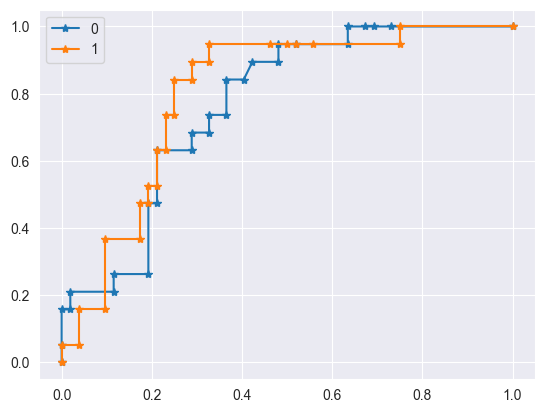

In [20]:
from experiments.models import HybridModel, ConvNextModel, AttentionFusion

spctr_model = ConvNextModel(name = 'convnext_tiny')
attention_fusion = AttentionFusion()
model = HybridModel(spctr_model=spctr_model, fusion=attention_fusion)

hybrid_training_config = TrainingConfig(
    fine_tune = True,
    device = device,
    model = model,
    train_dl = hybrid_dl_train,
    valid_dl = hybrid_dl_valid,
    optimizer = torch.optim.AdamW,
    weight_decay = 1,
    positive_class_weight = weight,
    lr_calculator = ExponentialLRCalculator(factor=0.5),
    epochs = 2,
    head_pretrain_epochs = 3,
    learning_rate = 1e-5,
    head_pretrain_learning_rate = 1e-3,
    mixed_precision = True,
    gradient_accumulation_size = 64
)

training = Training(hybrid_training_config)

training.run()

In [21]:
errors_report = training.trainer.cbs.callbacks[-3].get_eval_report()
errors_report.to_csv('errors_report.csv')

In [22]:
import torch

torch.save(model.w2v2, "hybrid_w2v_model.pth")
torch.save(model.w2v2.state_dict(), "hybrid_w2v_model_state_dict.pth")
torch.save(model.spctr_model, "hybrid_spctr_model.pth")
torch.save(model.spctr_model.state_dict(), "hybrid_spctr_model_state_dict.pth")
torch.save(model.head, "hybrid_head.pth")
torch.save(model.head.state_dict(), "hybrid_head_state_dict.pth")

# Errors analysis

In [23]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np

In [24]:
errors_report =  pd.read_csv('errors_report.csv', index_col=0)
errors_report['errors'] = -np.log(np.where(errors_report.targ==1, errors_report.pred, 1-errors_report.pred))
errors_report = errors_report.set_index('id')

In [25]:
report = errors_report.join(valid_data)

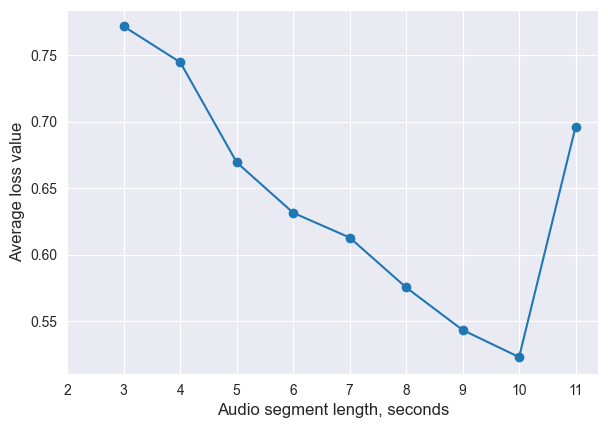

In [26]:
r1 = report.copy()
r1.dur = round(r1.dur).astype(int)
r1 = r1.groupby('dur').apply(lambda x: pd.Series({"cnt":len(x), "mean_loss":x['errors'].mean()}))
#_,ax = plt.subplots(1)
cm = 1/2.54  # centimeters in inches
_,ax = plt.subplots(figsize=(17.4*cm, 12*cm))
ax = r1['mean_loss'].plot(marker='o', ax=ax)
plt.ylabel('Average loss value',fontsize=12)
plt.xlabel('Audio segment length, seconds',fontsize=12)
ax.set_xticks([2,3,4,5,6,7,8,9,10,11])
plt.savefig(fname='lenloss', dpi=600)
#r1.cnt.plot.bar(rot=0,ax=ax[1])


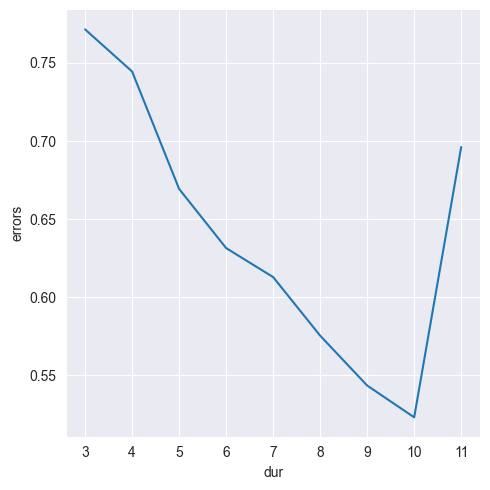

In [27]:
sns.relplot(data=report, x=round(report.dur), y='errors', kind="line", errorbar=None)

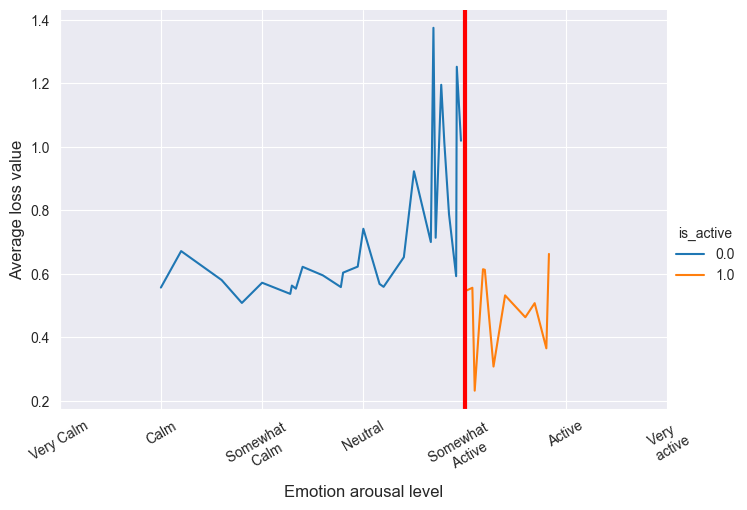

In [28]:
import seaborn as sns

cm = 1/2.54
sns.relplot(data=report, x="EmoAct", y="errors", kind="line", hue='is_active', errorbar=None,
            height=12*cm, aspect=(17.4/12))
ax = plt.gca()
ax.axvline(x=5, color='r', linewidth=3)
ax.set_xticks([1,2,3,4,5,6,7])
ax.set_xticklabels(['Very Calm', 'Calm', 'Somewhat \n Calm', 'Neutral', 'Somewhat \n Active', 'Active', 'Very \n active'], rotation=30);
plt.xlabel('Emotion arousal level',fontsize=12)
plt.ylabel('Average loss value', fontsize=12)
plt.annotate("Class boundary ->", (4.18, 1.9),
                 xycoords="data",
                 textcoords="offset points",
                 xytext=(0, 10), ha="center", fontsize=12)
plt.savefig(fname='actloss2', dpi=600,bbox_inches='tight')


<Axes: xlabel='EmoAct', ylabel='errors'>

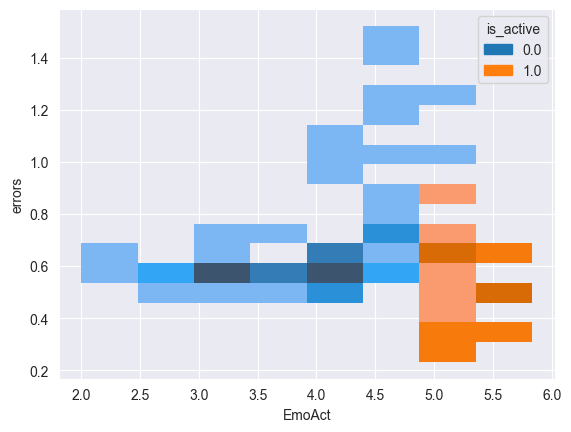

In [29]:
sns.histplot(data=report, x="EmoAct", y="errors", hue='is_active')

<Axes: xlabel='EmoClass'>

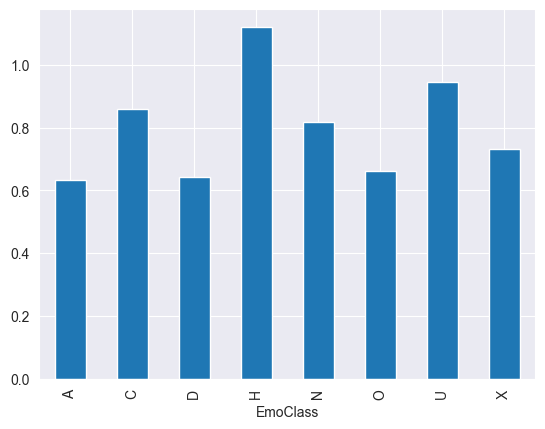

In [30]:
report[report['errors'] > 0.6].groupby('EmoClass').apply(lambda x: x['errors'].mean()).plot.bar()